# OISST Datetime Timestamp Management

In the `oisst_mainstays` data-stream we have netCDF files coming from two distribution centers:
 * The NOAA physical sciences laboratory (NOAA PSL)
 * National Center for Environmental Information (NCEI)

While the source data is the same, there is an inconsistency on the time-stamps that are recorded for each day. This difference is **usually** not an issue, because there is only one measurement per-day.

However, when these two data sources are combined there is the potential to have duplicate dates. This can happen because one data source labels measurements using a `12:00` noon timestamp (NCEI) & the other uses a midnight `00:00:00` timestamp (PSL).

This is an issue particularly in the regional timeseries that are being produced, as there are some duplicate dates slipping through in the 2020-2022 era. This notebook is for isolating how to check against this to implement those steps into `oisstools.py`

In [1]:
# Load Libraries
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4
import datetime
import os
import oisstools as ot


# Set the workspace - local/ docker
workspace = "local"
box_root = ot.set_workspace(workspace)
print(f"Working via {workspace} directory at: {box_root}")

Working via local directory at: /Users/akemberling/Library/CloudStorage/Box-Box/


# Load a Timeseries
The Gulf of Maine time series has known problems to check against, so I'll start there.

In [2]:
# 1. Load the Gulf of Maine
# Get their names from lookup catalog
region_collection = "gmri_sst_focal_areas"
region_names = ot.get_region_names(region_group = region_collection)
region_paths = ot.get_timeseries_paths(
    box_root = box_root, 
    region_group = region_collection, 
    region_list = region_names)


gom_sst = pd.read_csv(region_paths[0])
gom_sst.head()

,time,sst,area_wtd_sst,modified_ordinal_day,sst_clim,area_wtd_clim,clim_sd,sst_anom,area_wtd_anom
0,1981-09-01,15.780159,15.817860,245,16.430416,16.468410,2.270726,-0.650257,-0.650550
1,1981-09-02,15.787786,15.823025,246,16.356068,16.393608,2.245650,-0.568282,-0.570583
2,1981-09-03,15.494051,15.525661,247,16.299295,16.336779,2.232613,-0.805244,-0.811118
3,1981-09-04,14.993513,15.025630,248,16.261300,16.298191,2.201674,-1.267787,-1.272561
4,1981-09-05,14.843195,14.874094,249,16.145683,16.182520,2.176677,-1.302488,-1.308426


### Interrogate Data Structure

Find a way to separate the different date/time components to isolate the issue and label the different data streams.

In [3]:

# Interrogate the date structures
d = {
    'original': gom_sst.time, 
    'dates':    pd.to_datetime(gom_sst.time).dt.date,
    'times':    pd.to_datetime(gom_sst.time).dt.time
    }

# Here is the situation, timestamps jump based on data streams
new_df = pd.DataFrame(data=d)
new_df

,original,dates,times
0,1981-09-01,1981-09-01,00:00:00
1,1981-09-02,1981-09-02,00:00:00
2,1981-09-03,1981-09-03,00:00:00
3,1981-09-04,1981-09-04,00:00:00
4,1981-09-05,1981-09-05,00:00:00
...,...,...,...
15462,2022-12-01 12:00:00,2022-12-01,12:00:00
15463,2022-12-02 12:00:00,2022-12-02,12:00:00
15464,2022-12-03 12:00:00,2022-12-03,12:00:00
15465,2022-12-04 12:00:00,2022-12-04,12:00:00


### Date Duplications

The following dates have duplicate records due to the crossover in data suppliers.

In [4]:
# Find duplicates
dups = pd.to_datetime(gom_sst.time).dt.date.duplicated(keep = False)
gom_sst.loc[dups].time#.head(4)

14336    2020-12-01 00:00:00
14337    2020-12-01 12:00:00
14338    2020-12-02 00:00:00
14339    2020-12-02 12:00:00
14340    2020-12-03 00:00:00
                ...         
15123    2021-12-29 12:00:00
15124    2021-12-30 00:00:00
15125    2021-12-30 12:00:00
15126    2021-12-31 00:00:00
15127    2021-12-31 12:00:00
Name: time, Length: 792, dtype: object

### Method 1: The Blind Drop

The laziest way to handle this is to just drop the duplicates. This is problematic because 1) we lose those dates, and 2) we want to preferentially allow one data provider over another when there are these cases.

In [5]:
# Filter out the duplicates

# Method 1: Blind-Drop
test_filter = gom_sst.loc[~dups]
f"We lose {(len(gom_sst) - len(test_filter))/2} days of data just dropping all duplicates."

'We lose 396.0 days of data just dropping all duplicates.'

## Method 2: Preferential Dropping

This approach takes a look at the dates to find duplicates, then uses the timestamp to determine data provider, and makes a preferential decision to keep one over the other.

In [6]:
# Method 2: Selective Drop
# We want to only keep the 00:00:00 timestamp for duplicates
# That is the stamp for the PSL, which I assume* is vetted before the annual file is published

# Arguments to make it a function
df_in = gom_sst
phase_out = "ncei"

# 1. Build out datetime structures
dt_array = {
    'original': df_in.time, 
    'dt'      : pd.to_datetime(df_in.time),
    'dates'   : pd.to_datetime(df_in.time).dt.date,
    'times'   : pd.to_datetime(df_in.time).dt.time
    }
dt_df = pd.DataFrame(data = dt_array)

# 2. Find/Flag Dupes
dt_df["date_dupes"] = dt_df.dates.duplicated(keep = False)
dt_df

# 2. Check dupes for the datetimes we wanna drop
dt_df["nc_source"] = np.where(dt_df.times == datetime.time(0), "psl", "ncei")
dt_df

# 3. Filter out the ones that have the "bad" timestamp, or the source to phase out
drops = np.where(dt_df.date_dupes & (dt_df.nc_source == phase_out), True, False)


# 4. Apply the filtering to the original dataframe
df_out = df_in.loc[~drops].copy()

# Get rid of the stupid timestamp entirely
df_out["time"] = pd.to_datetime(df_out.time).dt.date
df_out

,time,sst,area_wtd_sst,modified_ordinal_day,sst_clim,area_wtd_clim,clim_sd,sst_anom,area_wtd_anom
0,1981-09-01,15.780159,15.817860,245,16.430416,16.468410,2.270726,-0.650257,-0.650550
1,1981-09-02,15.787786,15.823025,246,16.356068,16.393608,2.245650,-0.568282,-0.570583
2,1981-09-03,15.494051,15.525661,247,16.299295,16.336779,2.232613,-0.805244,-0.811118
3,1981-09-04,14.993513,15.025630,248,16.261300,16.298191,2.201674,-1.267787,-1.272561
4,1981-09-05,14.843195,14.874094,249,16.145683,16.182520,2.176677,-1.302488,-1.308426
...,...,...,...,...,...,...,...,...,...
15462,2022-12-01,11.145498,11.174203,336,9.369423,9.387088,1.162213,1.776075,1.787115
15463,2022-12-02,11.374785,11.404417,337,9.333347,9.350935,1.158664,2.041438,2.053482
15464,2022-12-03,11.551937,11.581782,338,9.274778,9.292370,1.164355,2.277159,2.289412
15465,2022-12-04,11.592849,11.623452,339,9.170948,9.188208,1.154606,2.421901,2.435244


## Make a Function:

The goal of this function is to:
 1. Take a timeseries produced by this workflow, possibly containing a combination of NCEI and PSL data
 2. Check the dates for any duplication caused by the different data streams
 3. In those cases, prefer one source over another via an argument

<AxesSubplot:xlabel='time'>

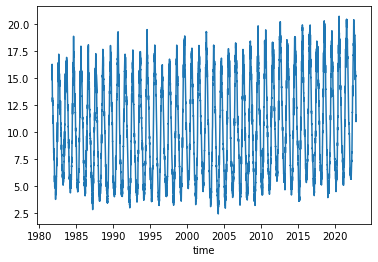

In [11]:
gom_cleaned = ot.date_source_prefer(df_in = gom_sst, phase_out = "ncei")
gom_cleaned.set_index("time").sst.plot()

In [13]:
## Save it to double check in R
gom_cleaned.to_csv("testing_data/gom_oisst.csv")

# Xarray QA/QC

This next part checks to see whether the date duplication is in the xarray datasets themselves, or if they are just the result of the repeated appending steps in pandas.

In [34]:
# See if they exist in the current Anomaly netCDF files


# Problematic years: 2020 & 2021
sst_check = ot.load_box_oisst(box_root, 2000, 2021, anomalies = False, do_parallel = False)
anoms_check = ot.load_box_oisst(box_root, 2000, 2021, anomalies = True, do_parallel = False)

## Debugging in xarray

The reason this even becomes an issue is when netCDF files from both sources are combined into a single xr.Dataset. When this happens both timestamps are introduced into the same object, and everything downstream from them deals with the consequences.

In [35]:
# Checking if there are different timestamps within a source:
np.unique(sst_check.time.dt.time)

array([datetime.time(0, 0)], dtype=object)

In [31]:
# And anomalies
np.unique(anoms_check.time.dt.time)

array([datetime.time(0, 0)], dtype=object)

## Looks fine!
Only unique timestamps in anomalies and sst (for years that aren't currently ongoing) are `datetime.time(0)`